A* and Greedy Best First Search

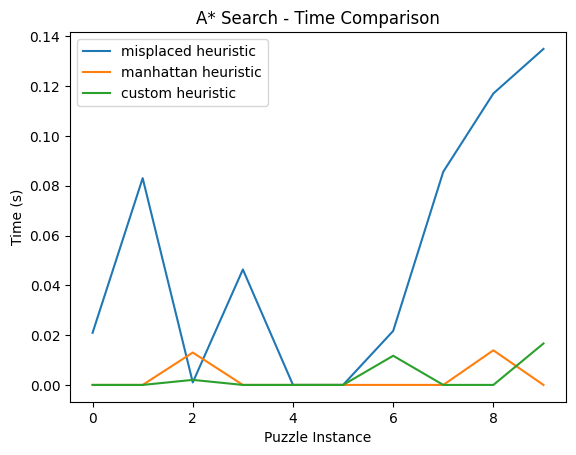

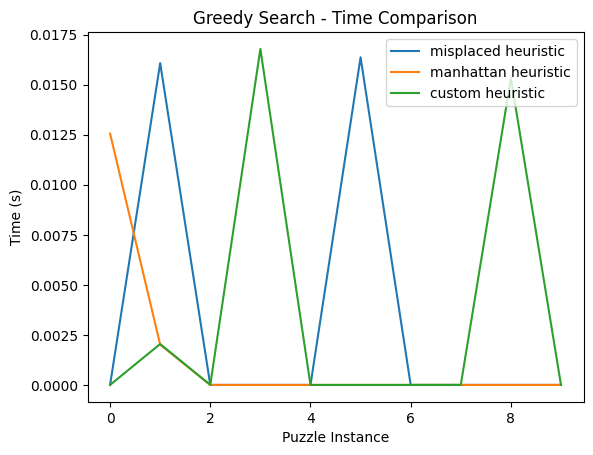

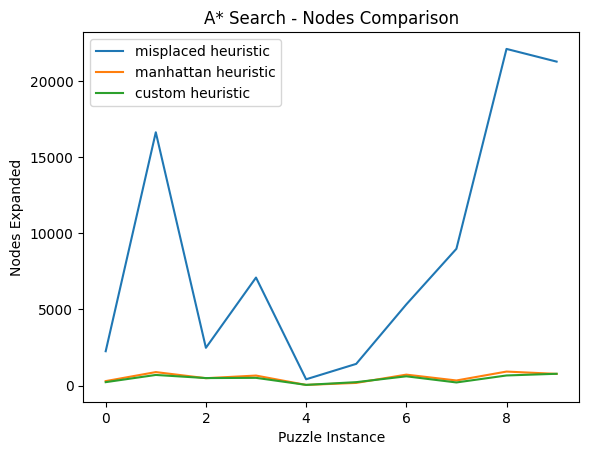

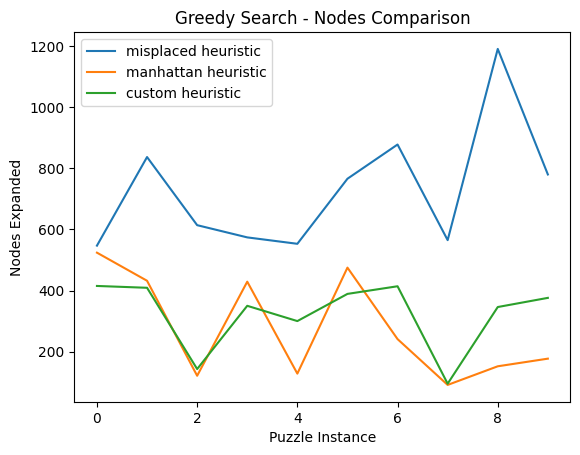

In [8]:
import numpy as np
import heapq
import time
import random
import matplotlib.pyplot as plt
from itertools import permutations

class NPuzzle:
    def __init__(self, n):
        self.n = n
        self.goal_state = self.generate_goal_state()
        self.initial_states = self.generate_initial_states(10)

    def generate_goal_state(self):
        return tuple(range(1, self.n**2)) + (0,)

    def generate_initial_states(self, num_states):
        states = set()
        while len(states) < num_states:
            puzzle = list(self.goal_state)
            random.shuffle(puzzle)
            if self.is_solvable(puzzle):
                states.add(tuple(puzzle))
        return list(states)

    def is_solvable(self, puzzle):
        inv_count = sum(
            1
            for i in range(len(puzzle))
            for j in range(i + 1, len(puzzle))
            if puzzle[i] and puzzle[j] and puzzle[i] > puzzle[j]
        )
        if self.n % 2 == 1:
            return inv_count % 2 == 0
        else:
            blank_row = (puzzle.index(0) // self.n) + 1
            return (inv_count + blank_row) % 2 == 0

    def get_neighbors(self, state):
        n = self.n
        idx = state.index(0)
        row, col = divmod(idx, n)
        neighbors = []
        moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]

        for dr, dc in moves:
            new_row, new_col = row + dr, col + dc
            if 0 <= new_row < n and 0 <= new_col < n:
                new_idx = new_row * n + new_col
                new_state = list(state)
                new_state[idx], new_state[new_idx] = new_state[new_idx], new_state[idx]
                neighbors.append(tuple(new_state))
        return neighbors

    def heuristic_misplaced(self, state):
        return sum(1 for i in range(len(state)) if state[i] and state[i] != self.goal_state[i])

    def heuristic_manhattan(self, state):
        n = self.n
        return sum(
            abs((val - 1) // n - i // n) + abs((val - 1) % n - i % n)
            for i, val in enumerate(state)
            if val != 0
        )

    def heuristic_custom(self, state):
        return self.heuristic_manhattan(state) + self.heuristic_misplaced(state) // 2

    def solve_puzzle(self, state, algorithm, heuristic):
        start_time = time.time()
        open_set = []
        heapq.heappush(open_set, (0, state, []))
        visited = set()
        nodes_expanded = 0

        while open_set:
            _, current_state, path = heapq.heappop(open_set)
            nodes_expanded += 1
            if current_state == self.goal_state:
                return len(path), time.time() - start_time, nodes_expanded
            
            if current_state in visited:
                continue
            visited.add(current_state)
            
            for neighbor in self.get_neighbors(current_state):
                if neighbor not in visited:
                    cost = len(path) + 1
                    h = heuristic(neighbor)
                    f = h if algorithm == 'Greedy' else cost + h
                    heapq.heappush(open_set, (f, neighbor, path + [neighbor]))
        return None, None, None  # Failed to solve within time limit

    def run_experiments(self):
        results = {algo: {h: [] for h in ('misplaced', 'manhattan', 'custom')} for algo in ('A*', 'Greedy')}
        heuristics = {'misplaced': self.heuristic_misplaced, 'manhattan': self.heuristic_manhattan, 'custom': self.heuristic_custom}
        
        for state in self.initial_states:
            for algo in ('A*', 'Greedy'):
                for h_name, heuristic in heuristics.items():
                    steps, elapsed, nodes = self.solve_puzzle(state, algo, heuristic)
                    if elapsed is not None:
                        results[algo][h_name].append((steps, elapsed, nodes))
        return results

    def plot_results(self, results):
        for metric in ['time', 'nodes']:
            for algo in ['A*', 'Greedy']:
                plt.figure()
                for h in results[algo]:
                    values = [x[1] if metric == 'time' else x[2] for x in results[algo][h] if x[1] is not None]
                    plt.plot(range(len(values)), values, label=f'{h} heuristic')
                plt.xlabel('Puzzle Instance')
                plt.ylabel('Time (s)' if metric == 'time' else 'Nodes Expanded')
                plt.title(f'{algo} Search - {metric.capitalize()} Comparison')
                plt.legend()
                plt.show()

if __name__ == '__main__':
    n = int(input("Enter n for n-puzzle (e.g., 3 for 8-puzzle, 4 for 15-puzzle): "))
    puzzle = NPuzzle(n)
    results = puzzle.run_experiments()
    puzzle.plot_results(results)

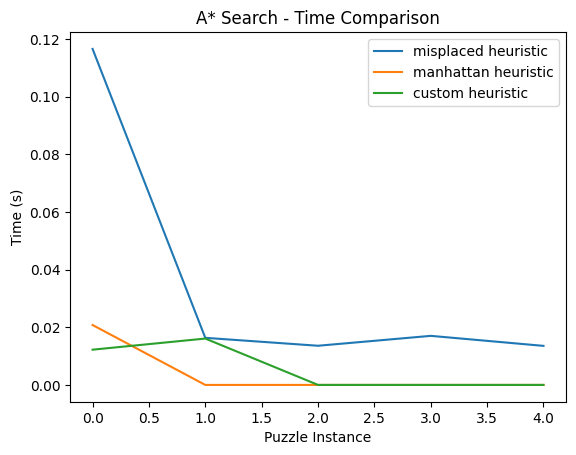

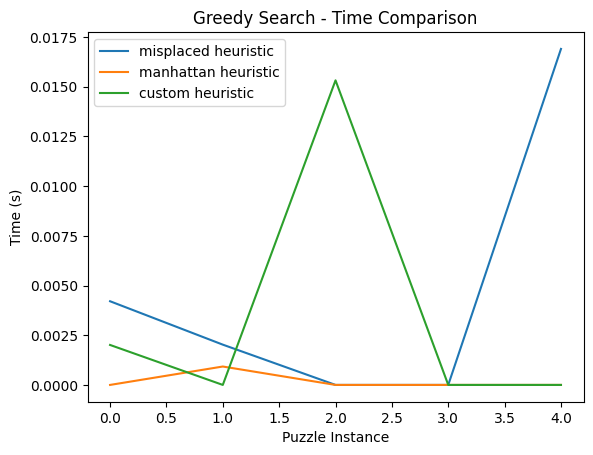

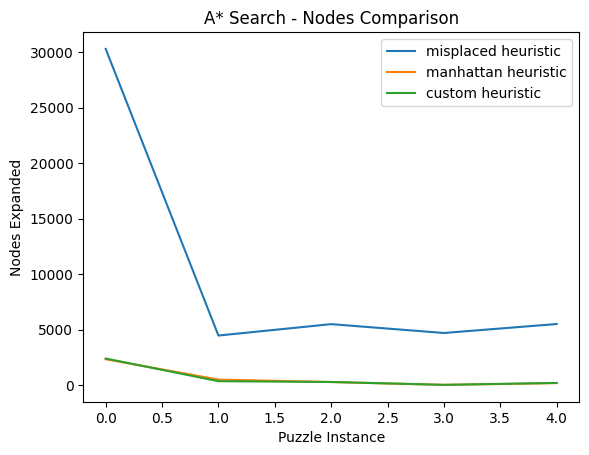

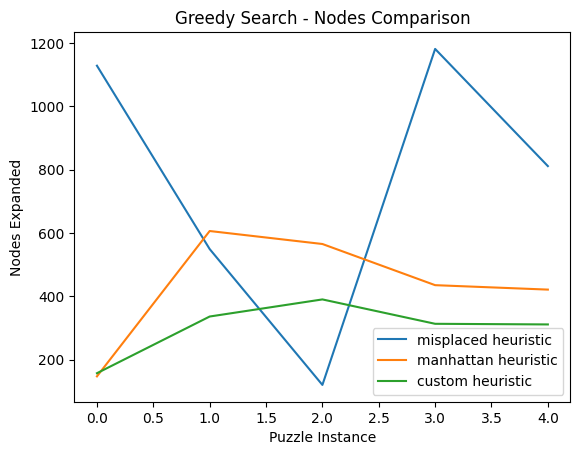

In [3]:

import numpy as np
import heapq
import time
import random
import matplotlib.pyplot as plt

def generate_goal_state(n):
    goal_state = tuple(range(1, n**2)) + (0,)
    return goal_state

def generate_initial_states(goal_state, n, num_states):
    states = set()
    while len(states) < num_states:
        puzzle = list(goal_state)
        random.shuffle(puzzle)
        states.add(tuple(puzzle))
    return list(states)

def get_neighbors(state, n):
    idx = state.index(0)
    row, col = divmod(idx, n)
    neighbors = []
    moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    for dr, dc in moves:
        new_row = row + dr
        new_col = col + dc
        if 0 <= new_row < n and 0 <= new_col < n:
            new_idx = new_row * n + new_col
            new_state = list(state)
            new_state[idx], new_state[new_idx] = new_state[new_idx], new_state[idx]
            neighbors.append(tuple(new_state))
    return neighbors

def heuristic_misplaced(state, goal_state):
    misplaced_tiles = 0
    for i in range(len(state)):
        if state[i] and state[i] != goal_state[i]:
            misplaced_tiles += 1
    return misplaced_tiles

def heuristic_manhattan(state, n):
    total_distance = 0
    for i, val in enumerate(state):
        if val != 0:
            goal_row, goal_col = (val - 1) // n, (val - 1) % n
            curr_row, curr_col = i // n, i % n
            total_distance += abs(goal_row - curr_row) + abs(goal_col - curr_col)
    return total_distance

def heuristic_custom(state, goal_state, n):
    return heuristic_manhattan(state, n) + heuristic_misplaced(state, goal_state) // 2

def solve_puzzle(state, goal_state, n, algorithm, heuristic):
    start_time = time.time()
    open_set = []
    heapq.heappush(open_set, (0, state, []))
    visited = set()
    nodes_expanded = 0

    while open_set:
        _, current_state, path = heapq.heappop(open_set)
        nodes_expanded += 1
        if current_state == goal_state:
            end_time = time.time()
            total_time = end_time - start_time
            return len(path), total_time, nodes_expanded
        
        if current_state in visited:
            continue
        visited.add(current_state)
        
        for neighbor in get_neighbors(current_state, n):
            if neighbor not in visited:
                cost = len(path) + 1
                heuristic_cost = heuristic(neighbor)
                if algorithm == 'Greedy':
                    f = heuristic_cost
                else:
                    f = cost + heuristic_cost
                heapq.heappush(open_set, (f, neighbor, path + [neighbor]))
    return None, None, None  # Failed to solve within time limit

def run_experiments(n, num_states=10):
    goal_state = generate_goal_state(n)
    initial_states = generate_initial_states(goal_state, n, num_states)
    
    heuristics = {
        'misplaced': lambda state: heuristic_misplaced(state, goal_state),
        'manhattan': lambda state: heuristic_manhattan(state, n),
        'custom': lambda state: heuristic_custom(state, goal_state, n)
    }
    
    results = {algo: {h: [] for h in heuristics} for algo in ('A*', 'Greedy')}
    
    for state in initial_states:
        for algo in ('A*', 'Greedy'):
            for h_name, heuristic in heuristics.items():
                steps, elapsed, nodes = solve_puzzle(state, goal_state, n, algo, heuristic)
                if elapsed is not None:
                    results[algo][h_name].append((steps, elapsed, nodes))
    return results

def plot_results(results):
    for metric in ['time', 'nodes']:
        for algo in ['A*', 'Greedy']:
            plt.figure()
            for h in results[algo]:
                values = [x[1] if metric == 'time' else x[2] for x in results[algo][h] if x[1] is not None]
                plt.plot(range(len(values)), values, label=f'{h} heuristic')
            plt.xlabel('Puzzle Instance')
            plt.ylabel('Time (s)' if metric == 'time' else 'Nodes Expanded')
            plt.title(f'{algo} Search - {metric.capitalize()} Comparison')
            plt.legend()
            plt.show()

n = int(input("Enter n for n-puzzle (e.g., 3 for 8-puzzle, 4 for 15-puzzle): "))
results = run_experiments(n)
plot_results(results)
